In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aquarium-data-cots/aquarium_pretrain/README.dataset.txt
/kaggle/input/aquarium-data-cots/aquarium_pretrain/README.roboflow.txt
/kaggle/input/aquarium-data-cots/aquarium_pretrain/data.yaml
/kaggle/input/aquarium-data-cots/aquarium_pretrain/valid/labels/IMG_2637_jpeg_jpg.rf.fb8a2e97a480a468812b0217a6fc5ce0.txt
/kaggle/input/aquarium-data-cots/aquarium_pretrain/valid/labels/IMG_2517_jpeg_jpg.rf.3f3fc94274355ee95214b0ca0c7b0734.txt
/kaggle/input/aquarium-data-cots/aquarium_pretrain/valid/labels/IMG_2367_jpeg_jpg.rf.0f66a0ca8366d9c38e41eb2936629bdb.txt
/kaggle/input/aquarium-data-cots/aquarium_pretrain/valid/labels/IMG_8572_MOV-1_jpg.rf.1c182e819e3efef65b32f7ef780942f8.txt
/kaggle/input/aquarium-data-cots/aquarium_pretrain/valid/labels/IMG_2323_jpeg_jpg.rf.035c5370cfa9efce40a515ce4ec72179.txt
/kaggle/input/aquarium-data-cots/aquarium_pretrain/valid/labels/IMG_8465_jpg.rf.4e9f92133e269119a82e502339b7981e.txt
/kaggle/input/aquarium-data-cots/aquarium_pretrain/valid/labels/IMG_23

In [2]:
train_images_path = os.path.join('/kaggle/input/aquarium-data-cots/aquarium_pretrain/train/images')
train_bbox_path = os.path.join('/kaggle/input/aquarium-data-cots/aquarium_pretrain/train/labels')
val_images_path = os.path.join('/kaggle/input/aquarium-data-cots/aquarium_pretrain/valid/images')
val_bbox_path = os.path.join('/kaggle/input/aquarium-data-cots/aquarium_pretrain/valid/labels')
test_images_path = os.path.join('/kaggle/input/aquarium-data-cots/aquarium_pretrain/test/images')
test_bbox_path = os.path.join('/kaggle/input/aquarium-data-cots/aquarium_pretrain/test/labels')

In [3]:
image_files = [f for f in os.listdir(train_images_path) if f.endswith('.jpg')]

In [4]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from PIL import Image
import os
import matplotlib.pyplot as plt 
import matplotlib.patches as patches

In [5]:
train_images_path = os.path.join('/kaggle/input/aquarium-data-cots/aquarium_pretrain/train/images')
train_bbox_path = os.path.join('/kaggle/input/aquarium-data-cots/aquarium_pretrain/train/labels')
val_images_path = os.path.join('/kaggle/input/aquarium-data-cots/aquarium_pretrain/valid/images')
val_bbox_path = os.path.join('/kaggle/input/aquarium-data-cots/aquarium_pretrain/valid/labels')
test_images_path = os.path.join('/kaggle/input/aquarium-data-cots/aquarium_pretrain/test/images')
test_bbox_path = os.path.join('/kaggle/input/aquarium-data-cots/aquarium_pretrain/test/labels')

In [6]:
image_files = [f for f in os.listdir(train_images_path) if f.endswith('.jpg')]

In [7]:
def backbone_cnn():
    resnet = torchvision.models.resnet101(pretrained=True)
    backbone = nn.Sequential(*(list(resnet.children())[:-2]))
    backbone.out_channels = 2048
    return backbone

In [8]:
def giou(boxes1, boxes2):
    area_boxes1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area_boxes2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

    lt = torch.max(boxes1[:, :2], boxes2[:, :2])  
    rb = torch.min(boxes1[:, 2:], boxes2[:, 2:])  

    wh = (rb - lt).clamp(min=0)  
    inter = wh[:, 0] * wh[:, 1]  

    union = area_boxes1 + area_boxes2 - inter

    lt = torch.min(boxes1[:, :2], boxes2[:, :2])
    rb = torch.max(boxes1[:, 2:], boxes2[:, 2:])

    wh = (rb - lt).clamp(min=0) 
    close_area = wh[:, 0] * wh[:, 1] 
    iou = inter / union
    giou = iou - (close_area - union) / close_area.clamp(min=1e-10)
    return giou.mean()

In [9]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, annotation_dir, transform=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transform = transform
        self.image_paths = [os.path.join(self.image_dir, filename) for filename in os.listdir(self.image_dir) if filename.endswith('.jpg')]
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        annotation_path = os.path.join(self.annotation_dir, os.path.splitext(os.path.basename(img_path))[0] + '.txt')

        image = Image.open(img_path)
        if image.mode != 'RGB':
            image = image.convert("RGB")
        image_width, image_height = image.size  
        annotations = self.load_annotations(annotation_path, image_width, image_height)
        
        if self.transform:
            image = self.transform(image)

        if len(annotations) == 0:
            target = {"boxes": torch.zeros((0, 4), dtype=torch.float32), "labels": torch.zeros((0,), dtype=torch.int64)}
        else:
            boxes = torch.as_tensor([ann['boxes'] for ann in annotations], dtype=torch.float32)
            labels = torch.as_tensor([ann['labels'] for ann in annotations], dtype=torch.int64)
            target = {"boxes": boxes, "labels": labels}

        return image, target

    def load_annotations(self, annotation_file, image_width, image_height):
        annotations = []
        with open(annotation_file, 'r') as f:
            for line in f:
                values = line.strip().split()
                class_label = int(values[0])
                x_center_norm, y_center_norm, width_norm, height_norm = map(float, values[1:])

                x_center = x_center_norm * image_width
                y_center = y_center_norm * image_height
                width = width_norm * image_width
                height = height_norm * image_height
                x_min = x_center - (width / 2)
                y_min = y_center - (height / 2)
                x_max = x_center + (width / 2)
                y_max = y_center + (height / 2)

                annotations.append({
                    "boxes": [x_min, y_min, x_max, y_max],
                    "labels": class_label
                })
        return annotations

In [10]:
transform = transforms.Compose([
    transforms.ToTensor(),transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),transforms.Resize((220, 220))
])
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    if len(batch) == 0:
        return None, None
    return tuple(zip(*batch))

In [11]:
image_dir = '/kaggle/input/aquarium-data-cots/aquarium_pretrain/train/images'
annotation_dir = '/kaggle/input/aquarium-data-cots/aquarium_pretrain/train/labels'
image_dir_v = '/kaggle/input/aquarium-data-cots/aquarium_pretrain/valid/images'
annotation_dir_v = '/kaggle/input/aquarium-data-cots/aquarium_pretrain/valid/labels'

batch_size = 1
dataset = CustomDataset(image_dir, annotation_dir, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
dataset_v = CustomDataset(image_dir_v, annotation_dir_v, transform=transform)
dataloader_v = torch.utils.data.DataLoader(dataset_v, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

In [12]:
num_classes = 7
backbone = backbone_cnn()

anchor_generator = AnchorGenerator(sizes=((32, 64, 128),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

model = FasterRCNN(backbone,
                   num_classes=num_classes,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:02<00:00, 86.8MB/s] 


In [13]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

num_epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.train()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (

In [14]:

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch in dataloader:
        if batch[0] is None:
            continue
        images, targets = batch
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        
        losses.backward()
        optimizer.step()
        
        running_loss += losses.item()

    train_loss = running_loss / len(dataloader)
    train_losses.append(train_loss)

    val_running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch in dataloader_v:
            if batch[0] is None:
                continue
            images, targets = batch
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            val_running_loss += losses.item()


    val_loss = val_running_loss / len(dataloader_v)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch [1/20], Train Loss: 0.7230, Val Loss: 0.5671
Epoch [2/20], Train Loss: 0.5290, Val Loss: 0.4921
Epoch [3/20], Train Loss: 0.4713, Val Loss: 0.4581
Epoch [4/20], Train Loss: 0.4184, Val Loss: 0.4760
Epoch [5/20], Train Loss: 0.3938, Val Loss: 0.4487
Epoch [6/20], Train Loss: 0.3465, Val Loss: 0.4939
Epoch [7/20], Train Loss: 0.3024, Val Loss: 0.4441
Epoch [8/20], Train Loss: 0.2783, Val Loss: 0.4449
Epoch [9/20], Train Loss: 0.2603, Val Loss: 0.4737
Epoch [10/20], Train Loss: 0.2363, Val Loss: 0.4593
Epoch [11/20], Train Loss: 0.2195, Val Loss: 0.5180
Epoch [12/20], Train Loss: 0.2071, Val Loss: 0.5045
Epoch [13/20], Train Loss: 0.1890, Val Loss: 0.5347
Epoch [14/20], Train Loss: 0.1796, Val Loss: 0.5096
Epoch [15/20], Train Loss: 0.1687, Val Loss: 0.4952
Epoch [16/20], Train Loss: 0.1660, Val Loss: 0.5031
Epoch [17/20], Train Loss: 0.1513, Val Loss: 0.5570
Epoch [18/20], Train Loss: 0.1454, Val Loss: 0.4780
Epoch [19/20], Train Loss: 0.1418, Val Loss: 0.5473
Epoch [20/20], Train 

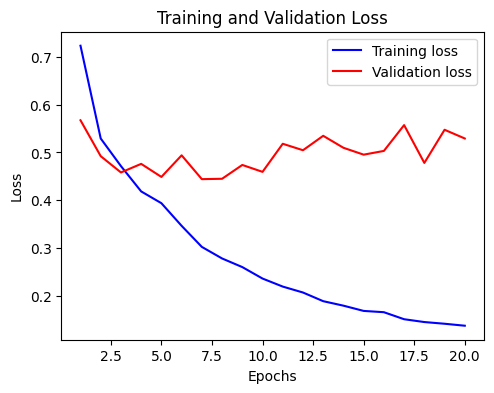

In [16]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
class_names = ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']

def evaluate_and_visualize(model, device, test_img, class_names, threshold=0.2):
    model.eval()
    with torch.no_grad():
        test_img = test_img.to(device)
        output = model([test_img])[0]  
    
    boxes = output['boxes'].cpu().numpy()
    labels = output['labels'].cpu().numpy()
    scores = output['scores'].cpu().numpy()

    print("Detection Results:")
    for box, label, score in zip(boxes, labels, scores):
        print(f"Box: {box}, Label: {label}, Score: {score}")

    image = Image.open(test_path)
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:
            x_min, y_min, x_max, y_max = box
            width, height = x_max - x_min, y_max - y_min
            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x_min, y_min, f'Label: {class_names[label]}, Score: {score:.2f}', fontsize=12, color='white', bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

In [22]:
image_dir_test = '/kaggle/input/aquarium-data-cots/aquarium_pretrain/test/images'
annotation_dir_test = '/kaggle/input/aquarium-data-cots/aquarium_pretrain/test/labels'

dataset_test = CustomDataset(image_dir_test, annotation_dir_test, transform=transform)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

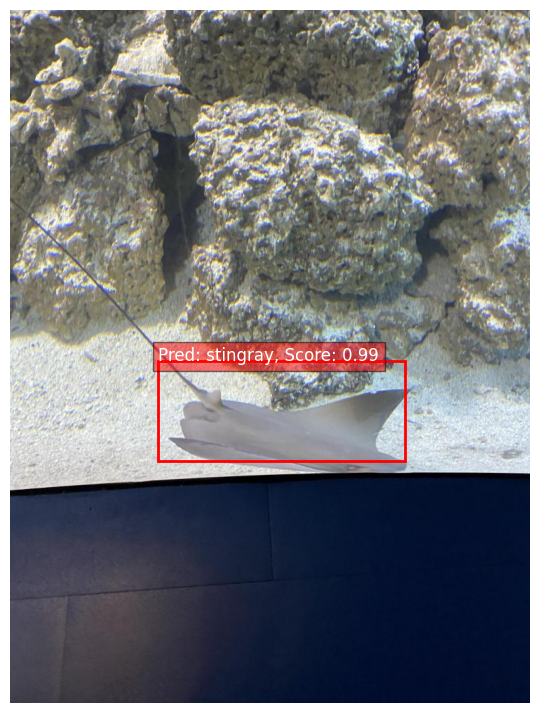

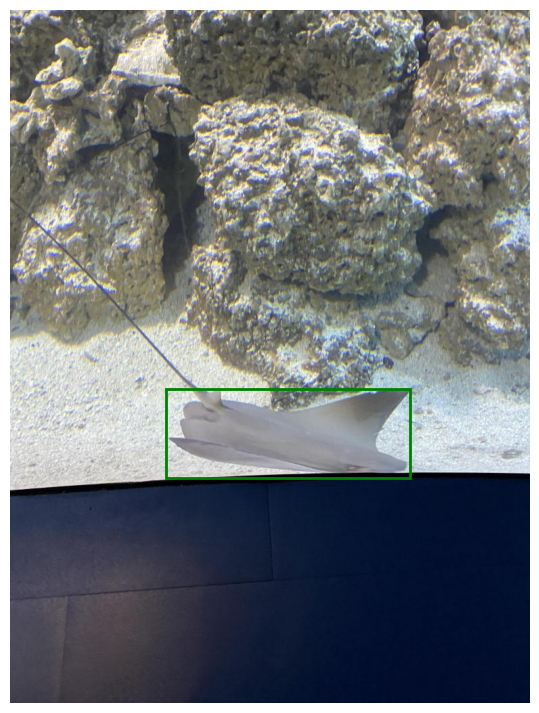

[[230.0, 559.5, 590.0, 690.5]]


In [37]:

def evaluate_and_visualize(model, device, test_img, class_names, threshold=0.4):
    model.eval()
    with torch.no_grad():
        test_img = test_img.to(device)
        output = model([test_img])[0]  
    
    boxes = output['boxes'].cpu().numpy()
    labels = output['labels'].cpu().numpy()
    scores = output['scores'].cpu().numpy()

    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(test_img.cpu().permute(1, 2, 0))  

    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:
            x_min, y_min, x_max, y_max = box
            width, height = x_max - x_min, y_max - y_min
            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x_min, y_min, f'Pred: {class_names[label]}, Score: {score:.2f}', fontsize=12, color='white', bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

for i, j in dataloader_test:
    bbox = j[0]['boxes'].tolist()
    evaluate_and_visualize(model, device, i[0], class_names)
    img = i[0]
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(img.cpu().permute(1, 2, 0))

    for k in bbox:
        x_min, y_min, x_max, y_max = k
        width, height = x_max - x_min, y_max - y_min
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        
    plt.axis('off')
    plt.show()
    print(bbox)
